In [1]:
## Python package imports 
import numpy as np
import matplotlib
import scipy.integrate as sint
import matplotlib.pyplot as plt

## respic imports
from rsrespic.fields import fields
from rsrespic.particles import particles
from rsrespic.solvers import solvers
from rsrespic.utilities import constants, diagnostics, utilities

## rsbeams imports
from rsbeams.rsptcls import bunch

## constants 
q = constants.cgs_constants['q']
c = constants.cgs_constants['c']
m_e = constants.cgs_constants['m_e']
m_p = constants.cgs_constants['m_p']
pi = np.pi


# Note that this example requires rsbeams

In [14]:
## Particle definitions 
Q_mks = 1.0e-50
ds = 0.1
s = 0.
emit = 4.0e-6
Q = constants.charge_mks_to_cgs(Q_mks)


## This is where we initialize a KV distribuiton
npart = 10000
newKVBunch = bunch.StandardBunch(npart, dist='KV', emitx = emit, emity = emit)
newKVBunch.set_longitudinal_coordinates(dpop=0.00) #here we reset the dpop value
newKVBunch.set_transverse_coordinates()

new_distribution = particles.distribution()
new_distribution.type = 'KV'
new_distribution.e_x = newKVBunch.emitx
new_distribution.e_y = newKVBunch.emity
new_distribution.N = newKVBunch.npart
new_distribution.x = newKVBunch.particles[:,0] * 100.
new_distribution.xp = newKVBunch.particles[:,1]
new_distribution.y = newKVBunch.particles[:,2] * 100.
new_distribution.yp = newKVBunch.particles[:,3]
new_distribution.z = newKVBunch.particles[:,4]
new_distribution.pz = newKVBunch.particles[:,5]

sigma_x = np.max(np.sqrt(new_distribution.x**2 + new_distribution.y**2))


## This is where we set the energy
E = 0.2e6

## Particle distributions
my_kv_beam = particles.particles_2D_delta(new_distribution, # dx_tent = 1 * L_min, dy_tent = 1 * L_min, 
    bunch_charge = Q, species_charge = q, species_mass = m_e, K_e = E)

# This is for the matrix map
my_kv_beam_matrix = new_distribution

## instantiate the diagnostics 
respic_diag = diagnostics.bunch_statistics()
matrix_diag = diagnostics.bunch_statistics(divergence_coordinates = True)



In [15]:
## Load the maps and define the stepper
maps = solvers.symplectic_maps()

## Define steppers
def step(particles, ds = ds):
    maps.drift(particles, ds = ds)

    
def step_matrix(particles, ds = ds):
    particles.x = particles.x + ds * particles.xp
    particles.y = particles.y + ds * particles.yp

In [16]:
## Here we run the simulation, 1000 steps using the stepper functions defined in the previous block
respic_diag.update(s, my_kv_beam)
matrix_diag.update(s, my_kv_beam_matrix)

k = 0

while k < 1000:

    step(my_kv_beam)
    step_matrix(my_kv_beam_matrix)
    
    s = s + ds
    
    respic_diag.update(s, my_kv_beam)
    matrix_diag.update(s, my_kv_beam_matrix)
    k = k + 1

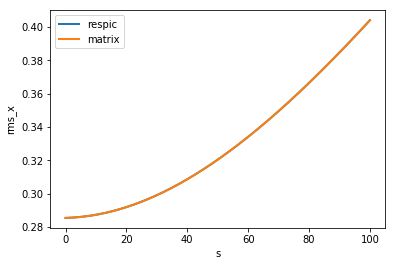

In [24]:
## Plotting 

x_key = 's'
y_key = 'rms_x'

plt.figure()
respic_diag.plot(x_key, y_key)
matrix_diag.plot(x_key, y_key)
plt.xlabel(x_key)
plt.ylabel(y_key)
plt.legend(['respic', 'matrix'])
plt.show()